# Neural Network

## I. Import and Load Data

Data was pulled from two sources. 

Solar Irradience data was pulled from the [National Solar Radiation Database](https://nsrdb.nrel.gov/). Pointwise GHI, DHI, and DNI data is returned hourly for an entire calendar year. All irradience values are recorded in w/m^2. Location is for a latitude longitude coordinate pair. Coordinates were chosen based on the locations of [U.S. Climate Reference Network (USCRN)](https://www.ncdc.noaa.gov/crn/) monitoring stations. This is because the USCRN has real time measurements of GHI, which can be used to make real-time predictions of DHI. The NRSDB is not updated so frequently. 

In addition to solar irradience data, this project uses other weather data such as cloud cover, air pressure, and season data to try and model the relationship between GHI and DHI. For that, this project pulls data from [darksky](https://darksky.net/dev).

In [139]:
import pandas as pd
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from random import randint

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [57]:
def featureHistograms(df, features=['GHI','DHI','Cloud Cover'],):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=len(features))
    for i in range(len(features)):
        sns.distplot(df[features[i]], ax=axs[i])

In [58]:
#Lets try and make a neural network

In [59]:
#Get 2018 Data
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')
print(_Testing_Data_Dir)

/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data


In [60]:
pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv')).head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,-22.5,0,0,0,8,...,0,62.75,103.76,0.69,978,0.1,296,2.1,1514739600,0.0
1,2018,1,1,1,30,-23.1,0,0,0,0,...,0,66.39,114.24,0.69,978,0.1,287,2.2,1514743200,0.0
2,2018,1,1,2,30,-23.6,0,0,0,8,...,0,69.34,125.01,0.69,978,0.1,283,2.3,1514746800,0.0
3,2018,1,1,3,30,-23.9,0,0,0,8,...,0,71.25,135.74,0.69,978,0.1,283,2.3,1514750400,0.0
4,2018,1,1,4,30,-24.1,0,0,0,8,...,0,72.87,145.93,0.69,979,0.1,284,2.3,1514754000,0.0


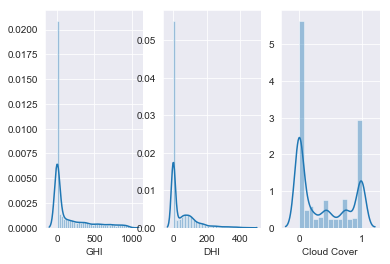

In [61]:
df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv'))
featureHistograms(df)

## II. Features and Data Engineering

So we have all the above variables....Which ones do we think would work best in a NN?

So we want to predict DHI, at the very least. Maybe DNI as well. What can we use to predict? 
[More Information on GHI, DHI, and DNI here!](https://firstgreenconsulting.wordpress.com/2012/04/26/differentiate-between-the-dni-dhi-and-ghi/#:~:text=Global%20Horizontal%20Irradiance%20(GHI)%20is,Diffuse%20Horizontal%20Irradiance%20(DHI).)

But a useful relationship to keep in mind is:

*Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)*

**GHI** is a must, as it is the primary metric our sensors will feed into such a model. 

**Cloud cover** is also essential, as cloud cover is one of the primary factors in how much direct normal solar irradience is diffused.

**Solar Zenith Angle** is important as it dictates how much irradience is direct normal (DNI)

Another useful relatinship to capture is **time**. We are given timestamps in addition to month, day, year, second, hour and minute variables. Timestamps and/or a combination between day + month would not be super useful, as it would overfit to the day. 
A more useful relationship would be to capture time of day. This is useful because in a non - featurized dataset, many GHI readings will read '0', simply because it is dark out. We are primarily concerned about the relationship between GHI and DHI, therefore factoring in readings when there is no sunlight to begin with could be confounding. Therefore adding in **minute** and **hour** variables in the input vector could adequately capture this relationship. 

Another solution would be to featurize this dataset, whereby we create a seperate feature which is a combination of day + time. OR, we could completly remove the nighttime entries entirely to ensure we only are concerned with readings that occur when the sun is out. However this occurs on a gradient, because sunlight is defracted even after sunset. So for now, let's just fit the model on the unedited dataset. 

Another good idea is to create a **season** variable, which is a dummy variable for each season (Fall, Winter, Spring, Summer), as different amounts of sunlight occur during each. The problem is that, for different locations on earth, seasonality could be inversely correlated with sunlight and thus GHI, DHI, and DNI. 

To keep the model as general as possible, we will exclude seasonality initially. 

Another useful metric is **Pressure**. According to the renowned [DISC model](https://www.nrel.gov/docs/legosti/old/3087.pdf), air pressure is included as a proxy for *air mass*, which is the amount of atmosphere solar rays have to travel through. The larger the solar mass, the more solar rays are scattered. 



### Loading the Data

In [88]:
#Get training arrays and combine them into a useable vector
"""
Useful params:
Hours
Cloud Cover
GHI
Solar Zenith
Pressure
"""

'\nUseful params:\nHours\nCloud Cover\nGHI\nSolar Zenith\nPressure\n'

In [63]:
def combine_training_arrays(df, input_arry, output_arr):
    ghi  = df['GHI'].values
    cloud_cover = df['Cloud Cover'].values
    hours = df['Hour'].values
    minutes = df['Minute'].values
    solar_zenith = df['Solar Zenith Angle'].values
    pressure = df['Pressure'].values
    dhi = df['DHI'].values
    #Sanity check, should all be 8760
    assert len(pressure)==len(solar_zenith)==len(minutes)==len(hours)==len(cloud_cover)==len(ghi)==8760, "len of input array not 8760"
    ar = np.array([ghi, cloud_cover, hours, minutes, solar_zenith, pressure]).T
    input_arry = np.concatenate((input_arry, ar))
    output_arr = np.concatenate((output_arr, np.array(dhi).T))
    return input_arry, output_arr


In [64]:
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
from glob import glob
for path in glob(_Testing_Data_Dir+'/*'):
    for file in glob(path+'/psm_'+'*'):
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]


In [65]:
#sanity check, make sure 8760*number of files we look at == 429240
count = 0
for path in glob(_Testing_Data_Dir+'/*'):
    for file in glob(path+'/psm_'+'*'):
        count+=1
print(count*8760)

429240


# III. Training

In [66]:
from tensorflow.keras.optimizers import Adam

In [67]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [68]:
#100 epochs, large batch size

In [69]:
# model = keras.Sequential()
# model.add(layers.Dense(300, activation="relu"))
# model.add(layers.Dense(200, activation="relu"))
# model.add(layers.Dense(100, activation="relu"))
# model.add(layers.Dense(50, activation="relu"))
# model.add(layers.Dense(25, activation="relu"))
# model.add(layers.Dense(1, activation='relu'))

In [70]:
# print(model)

In [71]:
# #Compile and train
# model.compile(optimizer=Adam(lr=0.0001), 
#               loss='mse',
#               metrics=['mae'])

# history = model.fit(input_arry, output_arry, epochs=100, batch_size=64)

In [72]:
# plt.plot(history.history['mae'])
# # plt.plot(history.history['val_acc'])
# plt.title('Mean Abs Error per Epoch')
# plt.ylabel('Mean Absolute Error')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()

In [73]:
#Epoch size of 50 seems reasonable

In [74]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [75]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [76]:
model = keras.Sequential()
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(200, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(25, activation="relu"))
model.add(layers.Dense(1, activation='relu'))

In [77]:
#Compile and train
model.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae'])

history = model.fit(input_arry, output_arry, epochs=100, batch_size=64)

Epoch 1/100
6707/6707 [==============================] - 12s 2ms/step - loss: 908.9349 - mae: 13.7560
Epoch 2/100
6707/6707 [==============================] - 10s 2ms/step - loss: 457.3915 - mae: 9.5208
Epoch 3/100
6707/6707 [==============================] - 10s 1ms/step - loss: 410.1036 - mae: 8.8879
Epoch 4/100
6707/6707 [==============================] - 10s 1ms/step - loss: 380.2950 - mae: 8.5337
Epoch 5/100
6707/6707 [==============================] - 10s 2ms/step - loss: 344.5573 - mae: 8.0490: 0s - loss: 345.4462 - mae: 8.061 - ETA: 0s - loss: 345.2730
Epoch 6/100
6707/6707 [==============================] - 10s 2ms/step - loss: 315.3614 - mae: 7.6791
Epoch 7/100
6707/6707 [==============================] - 10s 1ms/step - loss: 286.4006 - mae: 7.2552
Epoch 8/100
6707/6707 [==============================] - 11s 2ms/step - loss: 256.7065 - mae: 6.8142
Epoch 9/100
6707/6707 [==============================] - 11s 2ms/step - loss: 228.4354 - mae: 6.4044
Epoch 10/100
6707/6707 [=====

6707/6707 [==============================] - 13s 2ms/step - loss: 114.8853 - mae: 4.3826: 0s - loss: 114.7395 -
Epoch 76/100
6707/6707 [==============================] - 12s 2ms/step - loss: 114.4451 - mae: 4.3671: 0s - loss: 114.2813 - ma
Epoch 77/100
6707/6707 [==============================] - 12s 2ms/step - loss: 113.5232 - mae: 4.3671: 0s - loss: 113.2064 - mae: 4.3 - ETA: 0s - loss: 113.3275 - 
Epoch 78/100
6707/6707 [==============================] - 13s 2ms/step - loss: 113.6702 - mae: 4.3574
Epoch 79/100
6707/6707 [==============================] - 12s 2ms/step - loss: 111.5061 - mae: 4.3033: 2s - loss: 111.2165 - mae: 4.294 - ETA: 2s - loss: 111.2444 - 
Epoch 80/100
6707/6707 [==============================] - 12s 2ms/step - loss: 111.1495 - mae: 4.3035
Epoch 81/100
6707/6707 [==============================] - 13s 2ms/step - loss: 111.3231 - mae: 4.2869
Epoch 82/100
6707/6707 [==============================] - 12s 2ms/step - loss: 114.4429 - mae: 4.3850
Epoch 83/100
6707/6707

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2100      
_________________________________________________________________
dense_1 (Dense)              multiple                  60200     
_________________________________________________________________
dense_2 (Dense)              multiple                  20100     
_________________________________________________________________
dense_3 (Dense)              multiple                  5050      
_________________________________________________________________
dense_4 (Dense)              multiple                  1275      
_________________________________________________________________
dense_5 (Dense)              multiple                  26        
Total params: 88,751
Trainable params: 88,751
Non-trainable params: 0
____________________________________________________

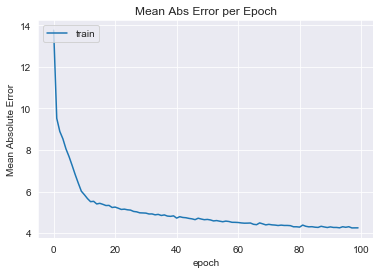

In [79]:
plt.plot(history.history['mae'])
# plt.plot(history.history['val_acc'])
plt.title('Mean Abs Error per Epoch')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [80]:
#MAE of around 4 w/m2. Considering DHI values go from 0 - 400, 4 represents a 1% error value

## Model Testing - Outer Banks

In [81]:
test_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'outer_banks', 'r_banks.csv'))
test_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,1.8,0,0,0,4,...,0,85.84,119.89,0.03,1026,1.2,350,8.6,1514782800,1.00
1,2018,1,1,1,30,1.6,0,0,0,4,...,0,87.76,132.05,0.03,1026,1.2,348,8.7,1514786400,0.94
2,2018,1,1,2,30,1.5,0,0,0,4,...,0,88.35,144.19,0.03,1026,1.1,346,8.7,1514790000,1.00
3,2018,1,1,3,30,1.4,0,0,0,4,...,0,89.16,155.85,0.03,1026,1.1,346,8.7,1514793600,1.00
4,2018,1,1,4,30,1.4,0,0,0,4,...,0,89.52,165.32,0.03,1026,1.1,347,8.9,1514797200,1.00


In [133]:
input_size = 6
test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
test_output_arry = np.array([], dtype=np.float64)
test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)

In [134]:
#keras model.evaluate reveals a mae of 6.9433 w/m2 in the outer banks test

In [135]:
score = model.evaluate(test_input_arry, test_output_arry, verbose=1)

274/274 [==============================] - 0s 1ms/step - loss: 274.9615 - mean_absolute_error: 7.5898


In [136]:
preds = model.predict(test_input_arry)

In [131]:
for i in range(len(preds)):
    preds[i] = float(preds[i])
    if preds[i] == 0:
        preds[i] = float(0.0001)
for i in range(len(test_output_arry)):
    test_output_arry[i] = float(test_output_arry[i])
    if test_output_arry[i] == 0.0:
        test_output_arry[i] = float(0.0001)

In [132]:
print("MAPE is ", np.mean(np.abs((test_output_arry - preds) / test_output_arry)) * 100)

MAPE is  40484772.703877665


In [166]:
#Compare random induvidual resutls!!!!!

In [167]:
i = randint(0,8760)
print("index is ",i)
print("Actual ",test_output_arry[i]," ","Predicted ", preds[i])

index is  7573
Actual  91.0   Predicted  [100.10162]


In [89]:
model.save('Neural_Net_1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Neural_Net_1/assets


# Neural Net Testing

#Lets take the global model and test in new locations


1. Outer Banks
2. Miami Florida (25.7617, -80.1918)
3. Boulder CO (40.035,-105.54)
4. San Diego CA (32.7157, -117.1611)
5. Lincoln Nebraska (40.848,-96.56)
6. Quinault Washington (47.513,-123.81)
7. Old Town Maine (44.928,-68.70)
8. Murphey Idaho (43.204,-116.75)
